In [88]:
import numpy as np
import rsatoolbox
from rsatoolbox.util.matrix import pairwise_contrast
from scipy.spatial.distance import squareform
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
from scipy import linalg

In [45]:
pairs = pairwise_contrast(np.arange(3))
pairs[pairs==-1]=1
pairs

array([[1., 1., 0.],
       [1., 0., 1.],
       [0., 1., 1.]])

In [46]:
np.zeros((6-4+1,6-4+1))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [47]:
T = np.block([[np.eye(3),np.zeros((6-4+1,6-4+1))],[0.5*pairs,np.diag(-0.5*np.ones(3))]])

In [48]:
vec_G = np.array([3,4,7,-1,2,-1])

In [49]:
G = np.diag(vec_G[0:3])+squareform(vec_G[3:len(vec_G)])

In [50]:
G

array([[ 3, -1,  2],
       [-1,  4, -1],
       [ 2, -1,  7]])

In [51]:
# create a dataset object
measurements = io.matlab.loadmat('92imageData/simTruePatterns.mat')
measurements = measurements['simTruePatterns2']
nCond = measurements.shape[0]
nVox = measurements.shape[1]
# now create a  dataset object
des = {'session': 1, 'subj': 1}
obs_des = {'conds': np.array(['cond_%02d' % x for x in np.arange(nCond)])}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
data = rsd.Dataset(measurements=measurements,
                   descriptors=des,
                   obs_descriptors=obs_des,
                   channel_descriptors=chn_des)

In [55]:
data.measurements.shape

(92, 100)

In [58]:
RDM_euc = rsr.calc_rdm(data, descriptor='conds')
RDM_euc.dissimilarities

(1, 4186)

In [68]:
#pairs.shape

4095+92-1

4186

In [73]:
print(pairs.shape)
print(np.diag(-0.5*np.ones(92-1)).shape)

(4095, 91)
(91, 91)


In [75]:
pairs = pairwise_contrast(np.arange(91))
pairs[pairs==-1]=1
pairs.shape
T = np.block([[np.eye(92-1),np.zeros((92-1,4186-92+1))],[0.5*pairs,np.diag(-0.5*np.ones(4186-92+1))]])

In [80]:
vec_G = RDM_euc.dissimilarities@np.transpose(T)

In [81]:
vec_G.shape

(1, 4186)

In [86]:
G = np.diag(vec_G[0,0:91])+squareform(vec_G[0,91:len(vec_G)])

In [95]:
np.max(linalg.eigvals(G))

(2.665013649930843+0j)

In [97]:
rdm=vec_G@linalg.inv(np.transpose(T))

In [101]:
np.sum(rdm-RDM_euc.dissimilarities)

-5.995204332975845e-15

In [102]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])

In [105]:
rdms_array.shape

(63, 4186)

In [106]:
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

In [108]:
model_rdms.dissimilarities.shape

(63, 4186)

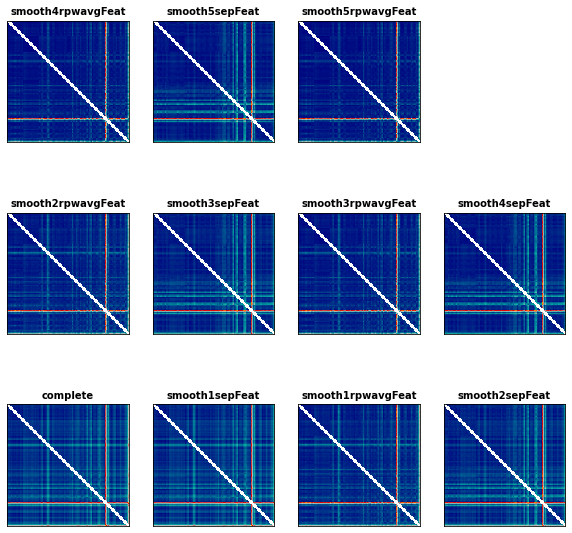

In [109]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
fig, ax, ret_val = rsatoolbox.vis.show_rdm(conv1_rdms, rdm_descriptor='measurement_model', figsize=(10,10))

In [113]:
conv1_rdms.get_vectors().shape

(11, 4186)